In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tools.data import DreemDatasets
from preprocessing import WignerVilleSpectrum, Compose
import matplotlib.pyplot as plt
from mtspec.util import signal_bursts
from matplotlib.cm import ScalarMappable
import torch
import torch.utils.data
from torchvision.models import vgg11
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from models.cnn import SimpleCNN

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
use_datasets = ['eeg_1']
seed = 1
batch_size = 4
use_cuda = True
lr = 0.001
momentum = 0.5
log_every = 10
n_epochs = 50

In [3]:
wigner_ville_spectrum = WignerVilleSpectrum(time_bandwidth=3.5)

dataset_transform_spectrum = {
    "eeg_1": wigner_ville_spectrum,
    #"eeg_2": wigner_ville_spectrum,
    #"eeg_3": wigner_ville_spectrum,
    #"eeg_4": wigner_ville_spectrum,
    #"eeg_5": wigner_ville_spectrum,
    #"eeg_6": wigner_ville_spectrum,
    # "eeg_7": wigner_ville_spectrum
}

## Charger les données

On est obligé de loader les données au fur et à mesure, sinon trop gros dataset (plus de 90Go !!)

In [4]:
train_set, val_set = DreemDatasets('dataset/train.h5', 'dataset/train_y.csv', 
                                   split_train_val=0.8, seed=seed, keep_datasets=use_datasets, 
                                   transforms=dataset_transform_spectrum, load_lazy=True).get()

train_set.load_data("dataset/all/train_split")
val_set.load_data("dataset/all/val_split")

train_set.close()
val_set.close()

Loading data in memory...
5412 in 1 datasets to load
Loading dataset eeg_1 ...


(1, 751, 1500)


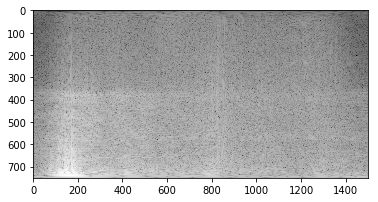

In [5]:
X, _, Y = train_set[6]
print(X.shape)
x = X.transpose(1, 2, 0)
x -= x.min()
x /= x.max()

plt.imshow(x.repeat(3, axis=2))

In [6]:
train_loader = torch.utils.data.DataLoader(train_set.torch_dataset(), 
                                           batch_size=batch_size, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set.torch_dataset(), batch_size=batch_size)

In [7]:
def get_model(n_classes):
    """
    Size of image at least 224x224
    """
    model = vgg11(pretrained=True)
    model_conv = nn.Sequential(*list(model.children())[:-1])
    for param in model_conv.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
        #nn.Linear(512 * 7 * 7, 4096),
        nn.Linear(141312, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, n_classes),
    )
    return model


model = SimpleCNN()

if use_cuda:
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=lr)

In [8]:
def transform_data(data50):
    data50 -= data50.min()
    data50 /= data50.max()
    data50 = data50.to(dtype=torch.float)

    return data50

In [9]:
def train_step(epoch):
    model.train()
    with tqdm(total=len(train_loader.dataset) / train_loader.batch_size) as t:
        for batch_id, (data_50hz, data_10hz, target) in enumerate(train_loader):
            if use_cuda:
                data_50hz, data_10hz, target = data_50hz.cuda(), data_10hz.cuda(), target.cuda()
            optimizer.zero_grad()
            
            data50 = transform_data(data_50hz)
            out50 = model(data50)
            
            criterion = nn.CrossEntropyLoss(reduction='elementwise_mean')
            loss = criterion(out50, target)

            loss.backward()
            optimizer.step()
            if batch_id % log_every == 0:
                t.set_description("Train - Epoch " + str(epoch))
                t.set_postfix_str("Loss: " + str(loss.data.item()))
            t.update()


In [10]:
def val_step(epoch):
    model.eval()

    validation_loss = 0
    correct = 0
    with tqdm(total=len(val_loader.dataset) / val_loader.batch_size) as t:
        for batch_id, (data_50hz, data_10hz, target) in enumerate(val_loader):
            if use_cuda:
                data_50hz, data_10hz, target = data_50hz.cuda(), data_10hz.cuda(), target.cuda()
            
            data50 = transform_data(data_50hz)
            out50 = model(data50)
            
            criterion = nn.CrossEntropyLoss(reduction='elementwise_mean')
            loss = criterion(out50, target)
            
            validation_loss += loss.data.item()
            # get the index of the max log-probability
            pred = out50.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
            if batch_id % log_every == 0:
                t.set_description("Val - Epoch " + str(epoch))
                t.set_postfix_str("Loss: " + str(loss.data.item()))
            t.update()

        validation_loss /= len(val_loader.dataset) / batch_size
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            validation_loss, correct, len(val_loader.dataset),
            100. * correct / len(val_loader.dataset)))


In [11]:
for epoch in range(n_epochs):
    train_step(epoch)
    val_step(epoch)

Train - Epoch 0: 100%|██████████| 1353/1353.0 [09:37<00:00,  2.31it/s, Loss: 1.6131410598754883]
Val - Epoch 0: : 339it [02:32,  2.90it/s, Loss: 1.6110470294952393]                          
  0%|          | 0/1353.0 [00:00<?, ?it/s]


Validation set: Average loss: 1.6130, Accuracy: 266/1353 (19%)



Train - Epoch 1: 100%|██████████| 1353/1353.0 [09:53<00:00,  2.29it/s, Loss: 1.6169257164001465]
Val - Epoch 1: : 339it [02:34,  2.90it/s, Loss: 1.6096199750900269]                          
  0%|          | 0/1353.0 [00:00<?, ?it/s]


Validation set: Average loss: 1.6131, Accuracy: 266/1353 (19%)



Train - Epoch 2: 100%|██████████| 1353/1353.0 [09:43<00:00,  2.33it/s, Loss: 1.6061995029449463]
Val - Epoch 2: : 339it [02:31,  2.87it/s, Loss: 1.6093621253967285]                          
  0%|          | 0/1353.0 [00:00<?, ?it/s]


Validation set: Average loss: 1.6131, Accuracy: 266/1353 (19%)



Train - Epoch 3:  35%|███▍      | 469/1353.0 [03:21<06:00,  2.46it/s, Loss: 1.6071093082427979]


KeyboardInterrupt: 